# Solving classification problems with CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)

Using the official Catboost Classification tutorial notebook on midterms dataset.

## Libraries installation

In [15]:
# !jupyter --version

In [16]:
#!pip install --user --upgrade catboost
#!pip install --user --upgrade ipywidgets
#!pip install shap
#!pip install sklearn
#!pip install --upgrade numpy
# !jupyter nbextension enable --py widgetsnbextension

In [17]:
import catboost
import sklearn
print(f'{catboost.__version__ = }')
print(f'{sklearn.__version__ = }')
!python --version

catboost.__version__ = '1.2.2'
sklearn.__version__ = '1.3.1'
Python 3.10.11


The system cannot find the path specified.


In [18]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
from catboost import *

In [19]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout
from scipy.stats import loguniform
from pprint import pprint
from tqdm import tqdm

# Configure the logging library.
logging.basicConfig(filename='randomizedcv_tuning.log', level=logging.INFO)

# Set the path to the current file 
current_file_path = Path().resolve()
print(f'{current_file_path = } ')

# Set the path to the data folder
data_folder_path = current_file_path / 'data'
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from src.config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


In [20]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

import catboost
from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, confusion_matrix, classification_report

## Reading the data

In [21]:
# graduate_in_5years simply labeled as 'target'
target_name = 'target'

In [22]:
# Data ingestion
def rebuild_df(features=None):
    print(f'{TARGET_NAME = }')
    data = CSVDataLoader().load('data/graduation_rate.csv')
    print(f'{features = }')
    print()
    print("- Preprocessor()...")
    data = Preprocessor().ColumnsSymbolReplacer(data)
    # display(data.head(2))
    data = Preprocessor().SymbolReplacer(data, 'parental_level_of_education')
    # display(data.head(2))
    data = Preprocessor().ColumnsDropper(data, TO_DROP)
    # display(data.head(2))
    data = Preprocessor().DataScaler(data)
    print()
    print("- FeatureBuilder()...")
    data = FeatureBuilder().TargetEncoder(data)
    # print("  -- Set COLS_CATEGORICAL astype(category)...")
    # data[COLS_CATEGORICAL] = data[COLS_CATEGORICAL].astype('category')
    print()
    print("- Prepare DFs...")
    print("  -- Split TARGET_NAME for y...")
    target = data[TARGET_NAME]
    print("  -- Dropping TARGET_NAME...")
    data = data.drop(columns=TARGET_NAME)
    
    if features:
        data = data[features] 
          
    df_full_train, df_test, y_full_train, y_test = train_test_split(data, target, test_size=0.2, random_state=11)
    
    # reset indices back to begin from 0
    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_full_train = y_full_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    return df_full_train, df_test, y_full_train, y_test

In [23]:
df_full_train, X_test, y_full_train, y_test = rebuild_df()
X_train, X_validation, y_train, y_validation = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=11)

TARGET_NAME = 'target'
Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 227.27it/s]

Finished processing the CSV file.
df.shape = (5000, 7)
features = None

- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...
  -- Scaling columns with MinMaxScaler()...
  -- Scaling columns with RobustScaler()...

- FeatureBuilder()...
  -- Creating 'target' column...

- Prepare DFs...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...


## Preparing your data

Categorical features declaration

In [24]:
cat_features = COLS_CATEGORICAL
print(cat_features)

['parental_level_of_education']


Looking on label balance in dataset

In [25]:
print('Labels: {}'.format(set(y_full_train)))
print('Zero count = {}, One count = {}'.format(len(y_full_train) - sum(y_full_train), sum(y_full_train)))

Labels: {0, 1}
Zero count = 2848, One count = 1152


In [81]:
y_full_train.value_counts(normalize=True)

target
0    0.712
1    0.288
Name: proportion, dtype: float64

Ways to create Pool class

In [26]:
X = df_full_train
y = y_full_train

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sat_total_score              4000 non-null   float64
 1   parental_level_of_education  4000 non-null   object 
 2   parental_income              4000 non-null   float64
 3   college_gpa                  4000 non-null   float64
dtypes: float64(3), object(1)
memory usage: 125.1+ KB


In [28]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool3 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 3:' + str(pool3.shape) +
      '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(4000, 4)
dataset 3:(4000, 4)
dataset 4: (4000, 4)


Column names
dataset 1:
['sat_total_score', 'parental_level_of_education', 'parental_income', 'college_gpa']

dataset 3:
['sat_total_score', 'parental_level_of_education', 'parental_income', 'college_gpa']

dataset 4:
['sat_total_score', 'parental_level_of_education', 'parental_income', 'college_gpa']


## Split your data into train and validation

In [29]:
y.shape

(4000,)

In [30]:
X.shape

(4000, 4)

## Selecting the objective function

Possible options for binary classification:

`Logloss`

`CrossEntropy` for probabilities in target

In [31]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


## Stdout of the training

In [32]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.25832
0:	learn: 0.6391267	test: 0.6431135	best: 0.6431135 (0)	total: 42ms	remaining: 588ms
1:	learn: 0.6024341	test: 0.6100105	best: 0.6100105 (1)	total: 91.1ms	remaining: 592ms
2:	learn: 0.5813501	test: 0.5918778	best: 0.5918778 (2)	total: 133ms	remaining: 533ms
3:	learn: 0.5649872	test: 0.5779797	best: 0.5779797 (3)	total: 187ms	remaining: 513ms
4:	learn: 0.5550799	test: 0.5701008	best: 0.5701008 (4)	total: 229ms	remaining: 457ms
5:	learn: 0.5482398	test: 0.5648167	best: 0.5648167 (5)	total: 281ms	remaining: 422ms
6:	learn: 0.5446207	test: 0.5617755	best: 0.5617755 (6)	total: 332ms	remaining: 380ms
7:	learn: 0.5409290	test: 0.5602945	best: 0.5602945 (7)	total: 384ms	remaining: 336ms
8:	learn: 0.5379173	test: 0.5595896	best: 0.5595896 (8)	total: 441ms	remaining: 294ms
9:	learn: 0.5345108	test: 0.5570748	best: 0.5570748 (9)	total: 490ms	remaining: 245ms
10:	learn: 0.5327344	test: 0.5565802	best: 0.5565802 (10)	total: 542ms	remaining: 197ms
11:	learn: 0.5308325	te

## Metrics calculation and graph plotting

In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Model comparison

In [34]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learning_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learning_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [35]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.01', 'learning_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Best iteration

In [36]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 18


## Cross-validation

In [38]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5331114937
bestIteration = 12

Training on fold [1/5]

bestTest = 0.5463648335
bestIteration = 11

Training on fold [2/5]

bestTest = 0.553846402
bestIteration = 4

Training on fold [3/5]

bestTest = 0.5525114526
bestIteration = 5

Training on fold [4/5]

bestTest = 0.5432721381
bestIteration = 13



In [39]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.597359,0.005797,0.593551,0.006557,0.604311,0.015461
1,1,0.565197,0.007590,0.557332,0.003034,0.651457,0.020001
2,2,0.555044,0.007176,0.542999,0.002900,0.662656,0.026559
3,3,0.550130,0.007915,0.535814,0.002656,0.670430,0.034208
4,4,0.549309,0.007836,0.532558,0.004355,0.674207,0.032763


In [40]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.5480±0.0085 on step 10


In [41]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5440653155
bestIteration = 8

Training on fold [1/5]

bestTest = 0.519644243
bestIteration = 14

Training on fold [2/5]

bestTest = 0.5660220812
bestIteration = 5

Training on fold [3/5]

bestTest = 0.54099258
bestIteration = 4

Training on fold [4/5]

bestTest = 0.5608135708
bestIteration = 3

Best validation Logloss score, stratified: 0.5483±0.0188 on step 8


## Overfitting detector

In [42]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
print(model_with_early_stop.tree_count_)

6


In [44]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [45]:
print(model_with_early_stop.tree_count_)

4


## Select decision boundary

In [46]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [47]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

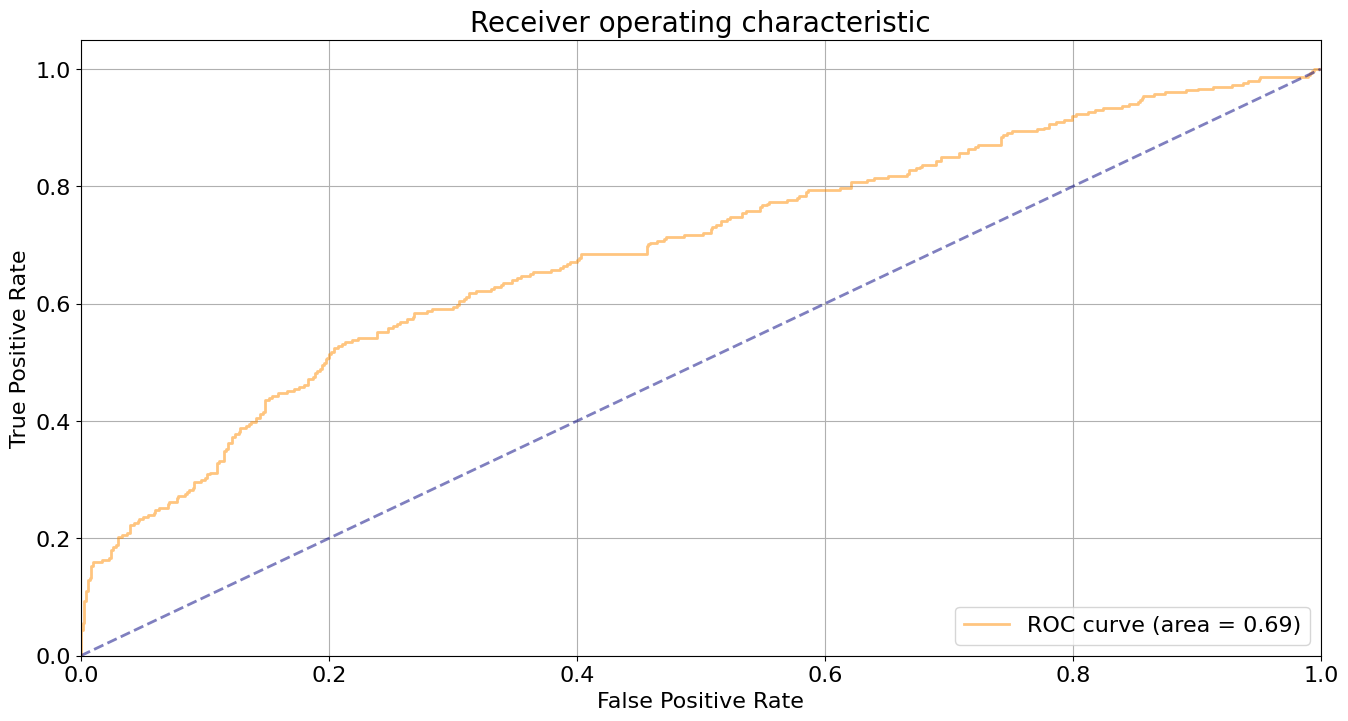

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [49]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

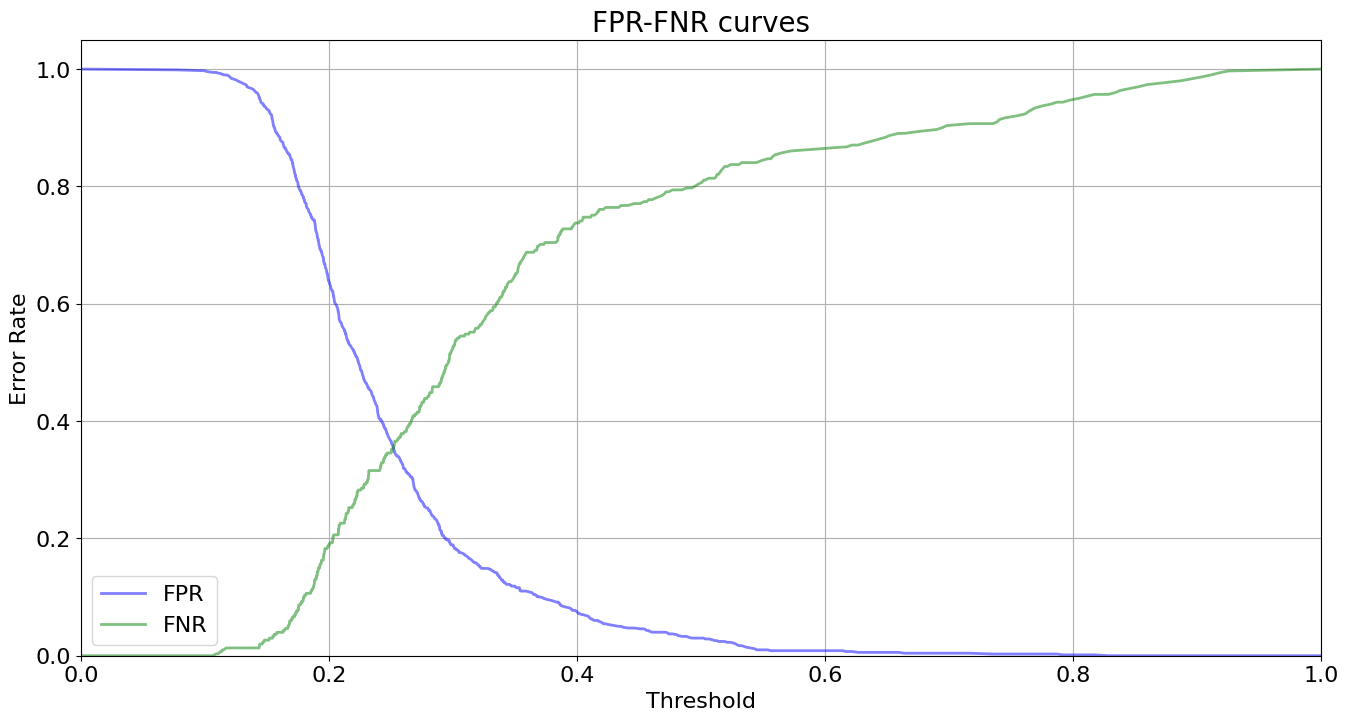

In [50]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [51]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.11520703401026638
0.5565612089151799


## Snapshotting

In [52]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=True
)

Learning rate set to 0.113177

bestTest = 0.5517674502
bestIteration = 53

Shrink model to first 54 iterations.


## Model predictions

In [53]:
# print(model.predict_proba(X=X_validation))

In [54]:
# print(model.predict(data=X_validation))

In [55]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
# print(raw_pred)

In [56]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

# print(probabilities)

In [57]:
# X_prepared = np.array(X_validation)
# For FeaturesData class categorial features must have type str

# fast_predictions = model.predict_proba(
#     X=FeaturesData(
#         cat_feature_data=X_validation[COLS_CATEGORICAL],
#         cat_feature_names=COLS_CATEGORICAL
#     )
# )
# print(fast_predictions)

## Staged prediction

In [58]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.5298 0.4702]
 [0.5298 0.4702]
 [0.5298 0.4702]
 ...
 [0.5327 0.4673]
 [0.5273 0.4727]
 [0.5168 0.4832]]
Iteration 1, predictions:
[[0.5537 0.4463]
 [0.5537 0.4463]
 [0.5537 0.4463]
 ...
 [0.5566 0.4434]
 [0.5402 0.4598]
 [0.5466 0.4534]]
Iteration 2, predictions:
[[0.5783 0.4217]
 [0.5702 0.4298]
 [0.5783 0.4217]
 ...
 [0.583  0.417 ]
 [0.56   0.44  ]
 [0.5731 0.4269]]
Iteration 3, predictions:
[[0.5884 0.4116]
 [0.5804 0.4196]
 [0.6049 0.3951]
 ...
 [0.6093 0.3907]
 [0.5767 0.4233]
 [0.5876 0.4124]]
Iteration 4, predictions:
[[0.6073 0.3927]
 [0.6023 0.3977]
 [0.6201 0.3799]
 ...
 [0.6306 0.3694]
 [0.5924 0.4076]
 [0.602  0.398 ]]


Doing predictions with ranking mode

In [60]:
import math
from copy import deepcopy

obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [0 0]
Probabilities [0.5 0.5]


## Metric evaluation on a new dataset

In [61]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_test, y_test,
    cat_features=cat_features,
    verbose=50
)

0:	learn: 0.6835545	total: 46.9ms	remaining: 9.34s
50:	learn: 0.5342423	total: 2.28s	remaining: 6.65s
100:	learn: 0.5047198	total: 4.68s	remaining: 4.59s
150:	learn: 0.4860519	total: 7.07s	remaining: 2.29s
199:	learn: 0.4704313	total: 9.29s	remaining: 0us


In [62]:
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
# print('AUC values:')
# print(np.array(metrics['AUC']))


## Feature importances

In [64]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,college_gpa,34.761263
1,parental_level_of_education,25.001580
2,sat_total_score,20.731050
3,parental_income,19.506107


## Shap values

In [65]:
shap_values = model.get_feature_importance(pool1, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(4000, 4)


In [66]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

In [67]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

In [68]:
df_full_train.columns

Index(['sat_total_score', 'parental_level_of_education', 'parental_income',
       'college_gpa'],
      dtype='object')

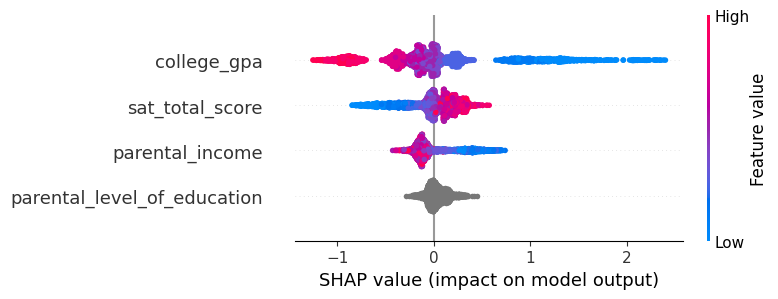

In [69]:
shap.summary_plot(shap_values, X)

In [70]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

## Feature evaluation

In [71]:
# from catboost.eval.catboost_evaluation import *
# learn_params = {'iterations': 20, # 2000
#                 'learning_rate': 0.5, # we set big learning_rate,
#                                       # because we have small
#                                       # #iterations
#                 'random_seed': 0,
#                 'verbose': False,
#                 'loss_function' : 'Logloss',
#                 'boosting_type': 'Plain'}
# evaluator = CatboostEvaluation('data/graduation_rate.csv',
#                                fold_size=2000, # <= 50% of dataset
#                                fold_count=20,
#                                column_description='data/train.cd',
#                                partition_random_seed=0,
#                                #working_dir=... 
# )
# result = evaluator.eval_features(learn_config=learn_params,
#                                  eval_metrics=['Logloss', 'Accuracy'],
#                                  features_to_eval=[6, 7, 8])

In [72]:
# from catboost.eval.evaluation_result import *
# logloss_result = result.get_metric_results('Logloss')
# logloss_result.get_baseline_comparison(
#     ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
# )

## Saving the model

In [73]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [74]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


## Hyperparameter tunning

### Training speed

In [75]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Accuracy

In [76]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Training the model after parameter tunning

In [77]:
best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

Learning rate set to 0.075914
0:	learn: 0.6713864	total: 59.1ms	remaining: 12.7s
100:	learn: 0.5146971	total: 5.03s	remaining: 5.72s
200:	learn: 0.4755220	total: 10.7s	remaining: 799ms
215:	learn: 0.4701571	total: 11.6s	remaining: 0us


## Calculate predictions for the contest

In [78]:
# X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictions:')
print(contest_predictions)

Predictions:
[[0.6734 0.3266]
 [0.7765 0.2235]
 [0.8373 0.1627]
 ...
 [0.7158 0.2842]
 [0.7749 0.2251]
 [0.7628 0.2372]]


## Prepare the submission

In [79]:
# f = open('submit.csv', 'w')
# f.write('Id,Action\n')
# for idx in range(len(contest_predictions)):
#     line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
#     f.write(line)
# f.close()

Submit your solution [here](https://www.kaggle.com/c/amazon-employee-access-challenge/submit).
Good luck!!!